# MNIST CNN
This mini-project was to learn more about TensorFlow and how to use TensorFlow datasets. I wanted to use the MNIST dataset as it is really easy to get started with.

In [1]:
# install tensorflow-addons just incase it isn't installed
!pip install tensorflow-addons

In [2]:
# import libraries that we may use
import tensorflow as tf

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from tqdm import tqdm
import numpy as np
import math
import os

In [3]:
# load in MNIST data from tensorflow_datasets
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=False, 
    as_supervised=True,
    with_info=True
)

In [4]:
@tf.function
def rotate(img, max_degrees=20):
  degrees = tf.random.uniform([], -max_degrees, max_degrees, dtype=tf.float32)
  radians = degrees * math.pi / 180 # convert degrees to radians
  img = tfa.image.rotate(img, radians, interpolation="BILINEAR")
  return img

@tf.function
def augment(image, label, w=28, h=28): # will be using tensorflow instead of opencv

  # resize image
  image = tf.image.resize(image, size=(w, h))

  # random coloring of image
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

  # rotate image
  image = rotate(image)
  return image, label

@tf.function
def normalize_img(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label


In [5]:
# Create dataset and preprocess them with the functions we just created
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

In [6]:
# Create model using the functional API
def create_model():
  inputs = tf.keras.Input(shape=(28, 28, 1))
  x = tf.keras.layers.Conv2D(32, 3)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = tf.keras.layers.MaxPooling2D(2, 2)(x)
  x = tf.keras.layers.Conv2D(64, 3)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = tf.keras.layers.MaxPooling2D(2, 2)(x) 
  x = tf.keras.layers.Conv2D(128, 3)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = tf.keras.layers.MaxPooling2D(2, 2)(x) 
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
  
  return tf.keras.Model(inputs=inputs, outputs=outputs)

model = create_model()

In [7]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])


In [8]:
# Summarize our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 128)       512       
_________________________________________________________________
tf.nn.relu_2 (TFOpLambda)    (None, 26, 26, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                138451

In [9]:
# Fit the model
history = model.fit(ds_train, epochs=30)

Epoch 1/30
938/938 [==============================] - 17s 11ms/step - loss: 0.2952 - accuracy: 0.9167
Epoch 2/30
938/938 [==============================] - 11s 11ms/step - loss: 0.1292 - accuracy: 0.9636
Epoch 3/30
938/938 [==============================] - 12s 12ms/step - loss: 0.1003 - accuracy: 0.9714
Epoch 4/30
938/938 [==============================] - 11s 12ms/step - loss: 0.0858 - accuracy: 0.9752
Epoch 5/30
938/938 [==============================] - 11s 11ms/step - loss: 0.0768 - accuracy: 0.9787
Epoch 6/30
938/938 [==============================] - 11s 11ms/step - loss: 0.0706 - accuracy: 0.9801
Epoch 7/30
938/938 [==============================] - 11s 12ms/step - loss: 0.0637 - accuracy: 0.9815
Epoch 8/30
938/938 [==============================] - 12s 12ms/step - loss: 0.0599 - accuracy: 0.9831
Epoch 9/30
938/938 [==============================] - 12s 12ms/step - loss: 0.0541 - accuracy: 0.9838
Epoch 10/30
938/938 [==============================] - 11s 11ms/step - loss: 0.050

Text(0, 0.5, 'Loss')

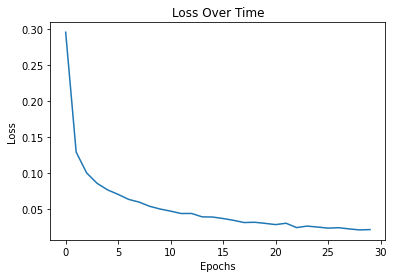

In [10]:
# Plot the loss curve
import matplotlib.pyplot as plt

plt.title("Loss Over Time")
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [11]:
# Evaluate the model
model.evaluate(ds_test)

157/157 [==============================] - 1s 8ms/step - loss: 0.0618 - accuracy: 0.9844


[0.061766065657138824, 0.9843999743461609]